In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX

from fbprophet import Prophet

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model

from tqdm import tqdm_notebook

In [2]:
def step_split(x_sequence, y_sequence, n_steps, n_features, n_forwards, n_predict_steps, test_set=False):
  x_sequence = np.array(x_sequence).reshape(-1, n_features)
  y_sequence = np.array(y_sequence).reshape(-1, 1)

  X, y = list(), list()
  if test_set:
    X = x_sequence[-n_steps:]
    X = np.array(X)
    X = X.reshape(1, n_steps, n_features)
  else:
    end = len(x_sequence) - n_steps - n_forwards - n_predict_steps + 2
    for i in range(end):
      seq_x = x_sequence[i:i+n_steps]
      seq_y = y_sequence[i+n_steps+n_forwards-1:i+n_steps+n_forwards+n_predict_steps-1]
      X.append(seq_x)
      y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], n_steps, n_features)
    y = y.reshape(y.shape[0], n_predict_steps)

  return X, y


def create_model(stateful,batch_size, n_steps, n_features):
    model = Sequential()
    model.add(LSTM(32,
                batch_input_shape=(batch_size, n_steps, n_features),
                stateful=stateful))
    model.add(Dense(1))
    optimizer = Adam()
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [3]:
df = pd.read_csv('Gold1.csv')

df = df.sort_values(by = 'datetime')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y/%m/%d")

df.index = df['datetime']

df = df.drop('datetime', axis = 1)

df = df['Gold_Price']



df.columns = ['Gold_Price']

df = pd.DataFrame(df)

gold_df = df

In [4]:

# 2000년 부터의 데이터만 사용
X = gold_df[gold_df.index >= datetime.datetime(2000,1,1)]
y = gold_df[gold_df.index >= datetime.datetime(2000,1,1)]


#LSTM의 학습과 예측 기간 설정
n_steps = 32
training_period = 512 + n_steps
n_features = 1
n_forwards = 1
n_predict_steps = 1

#테스트 기간 설정
end = len(X) - n_steps - training_period
validation_size = 1200
start = end - validation_size





#예측 결과를 담을 리스트 만들기
yhat_arima_list = list()
yhat_prophet_list = list()
yhat_logistic_prophet_list = list()
yhat_lstm_list = list()
y_real_list = list()
predict_index_list = list()

#LSTM의 학습 파라미터 설정
stateful = True
batch_size = 1
epochs = 1


#LSTM모델의 사전 학습
lstm_model = create_model(stateful,batch_size,n_steps,n_features)
data_x = X[start-training_period:start].values.reshape(-1, n_features)
data_y = y[start-training_period:start].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data_x)
data_x = scaler.transform(data_x)
data_y = scaler.transform(data_y)
x_train, y_train = step_split(data_x, data_y, n_steps,n_features, n_forwards, n_predict_steps)


pretrain_epoch = 60
for j in range(pretrain_epoch): 
  print(f'Epoch {j + 1}/{pretrain_epoch}')
  lstm_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=1,
                    verbose=2,
                    shuffle=False,
                    validation_split=0.1
                      )
  lstm_model.reset_states()



#one-step time series forecast시작
for i in tqdm_notebook(range(start, end)):
  # 학습은 과거 전 구간이 아닌 예측날 기준 512일 이전의 데이터만 학습하도록 하겠다.
  data = X[i:i+training_period+n_steps]
  y_real = X.values[i+training_period+n_steps].item()
  y_real_list.append(y_real)
  predict_index = X.index[i+training_period+n_steps].date()
  predict_index_list.append(predict_index)


  #SARIMA모델 정의와 학습
  sarima_model = SARIMAX(data.values, order=(0,1,1), seasonal_order=(0, 1, 1, 12), trend='c', enforce_stationarity=False, enforce_invertibility=False)
  model_fit = sarima_model.fit()
  sarima_forecast = model_fit.forecast(1).item()
  yhat_arima_list.append(sarima_forecast)
  
  #Prophet모델 정의와 학습
  prophet_model = Prophet(daily_seasonality = False)
  prophet_series = pd.DataFrame([data.index, data['Gold_Price']]).T
  prophet_series.columns = ['ds','y']
  prophet_model.fit(prophet_series)
  future =  prophet_model.make_future_dataframe(periods=1)
  prophet_forecast = prophet_model.predict(future[-1:])['yhat'].item()
  yhat_prophet_list.append(prophet_forecast)  


  #LSTM모델용 데이터 전처리 
  data_x = data.values.reshape(-1, n_features)
  data_y = data.values.reshape(-1, 1)


  scaler = MinMaxScaler(feature_range=(-1,1))
  scaler.fit(data_x)
  
  data_x = scaler.transform(data_x)
  data_y = scaler.transform(data_y)
  

  x_train, y_train = step_split(data_x, data_y, n_steps,n_features, n_forwards, n_predict_steps)
  x_test, _ = step_split(data_x, data_y, n_steps,n_features, n_forwards, n_predict_steps, True)
  
  #LSTM 모델 예측 실시
  lstm_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=1,
                    verbose=0,
                    shuffle=False
                      )
  lstm_model.reset_states()
  lstm_forecast = scaler.inverse_transform(lstm_model.predict(x_test, batch_size=batch_size)).item()
  yhat_lstm_list.append(lstm_forecast)

Epoch 1/60
460/460 - 2s - loss: 0.0170 - val_loss: 0.0512
Epoch 2/60
460/460 - 2s - loss: 0.0137 - val_loss: 0.0326
Epoch 3/60
460/460 - 2s - loss: 0.0095 - val_loss: 0.0287
Epoch 4/60
460/460 - 2s - loss: 0.0078 - val_loss: 0.0267
Epoch 5/60
460/460 - 2s - loss: 0.0065 - val_loss: 0.0247
Epoch 6/60
460/460 - 2s - loss: 0.0060 - val_loss: 0.0275
Epoch 7/60
460/460 - 2s - loss: 0.0057 - val_loss: 0.0282
Epoch 8/60
460/460 - 2s - loss: 0.0053 - val_loss: 0.0230
Epoch 9/60
460/460 - 2s - loss: 0.0051 - val_loss: 0.0240
Epoch 10/60
460/460 - 2s - loss: 0.0049 - val_loss: 0.0168
Epoch 11/60
460/460 - 2s - loss: 0.0048 - val_loss: 0.0212
Epoch 12/60
460/460 - 2s - loss: 0.0047 - val_loss: 0.0168
Epoch 13/60
460/460 - 2s - loss: 0.0043 - val_loss: 0.0165
Epoch 14/60
460/460 - 2s - loss: 0.0043 - val_loss: 0.0168
Epoch 15/60
460/460 - 2s - loss: 0.0039 - val_loss: 0.0164
Epoch 16/60
460/460 - 2s - loss: 0.0039 - val_loss: 0.0177
Epoch 17/60
460/460 - 2s - loss: 0.0040 - val_loss: 0.0172
Epoch 

  0%|          | 0/1200 [00:00<?, ?it/s]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [6]:
for i in tqdm_notebook(range(start, end)):
  data = X[i:i+training_period+n_steps]

  prophet_series = pd.DataFrame([data.index, data['Gold_Price']]).T
  prophet_series.columns = ['ds','y']
  prophet_model = Prophet(growth = 'logistic', daily_seasonality = False)
  prophet_series['cap'] = prophet_series['y'].shift() * 1.1
  prophet_series['floor'] = prophet_series['y'].shift() * 0.9
  prophet_series.fillna(method='bfill', inplace=True)

  prophet_model.fit(prophet_series)
  future =  prophet_model.make_future_dataframe(periods=1)
  future['cap'] = prophet_series['cap'].append(pd.Series(prophet_series['y'].values[-1]*1.1),ignore_index=True)
  future['floor'] = prophet_series['floor'].append(pd.Series(prophet_series['y'].values[-1]*0.9),ignore_index=True)
  future.fillna(method='bfill', inplace=True)


  prophet_forecast = prophet_model.predict(future[-1:])['yhat'].item()
  yhat_logistic_prophet_list.append(prophet_forecast)  

  0%|          | 0/1200 [00:00<?, ?it/s]

In [7]:
result_df = pd.DataFrame(list(zip(y_real_list, yhat_arima_list,yhat_prophet_list,yhat_logistic_prophet_list,yhat_lstm_list)),columns=['y','arima','prophet','prophet_logistic','lstm'],index=predict_index_list)
col_list = ['arima', 'prophet','prophet_logistic','lstm']
for col in col_list:
  mse = mean_squared_error(result_df['y'], result_df[col])
  print(f'{col} error: {mse}')

arima error: 435.36379729157403
prophet error: 1298.7519447702728
prophet_logistic error: 1273.2133713430826
lstm error: 1171.2909494471314


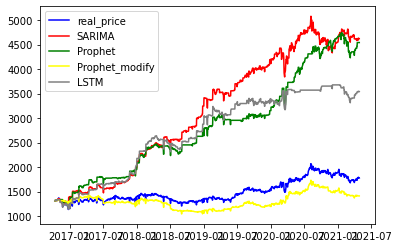

In [8]:
result_df = pd.DataFrame(list(zip(y_real_list, yhat_arima_list,yhat_prophet_list,yhat_logistic_prophet_list,yhat_lstm_list)),columns=['y','arima','prophet','prophet_logistic','lstm'],index=predict_index_list)
result_df['ratio'] = result_df['y'].diff() / result_df['y'].shift()
result_df['y_shifted'] = result_df['y'].shift()
result_df['arima_direction'] = result_df.apply(lambda x: 1 if (x['arima'] - x['y_shifted']) > 0 else 0, axis=1) 
result_df['prophet_direction'] = result_df.apply(lambda x: 1 if (x['prophet'] - x['y_shifted']) > 0 else 0, axis=1) 
result_df['prophet_logistic_direction'] = result_df.apply(lambda x: 1 if (x['prophet_logistic'] - x['y_shifted']) > 0 else 0, axis=1) 
result_df['lstm_direction'] = result_df.apply(lambda x: 1 if (x['lstm'] - x['y_shifted']) > 0 else 0, axis=1) 

result_df['arima_simulation'] = result_df['y'][0]
result_df['prophet_simulation'] = result_df['y'][0]
result_df['prophet_logistic_simulation'] = result_df['y'][0]
result_df['lstm_simulation'] = result_df['y'][0]

for i in range(1,len(result_df)):
  result_df['arima_simulation'][i] = result_df['arima_simulation'][i-1] *(1 + result_df['arima_direction'][i]*result_df['ratio'][i])
  result_df['prophet_simulation'][i] = result_df['prophet_simulation'][i-1] *(1 + result_df['prophet_direction'][i]*result_df['ratio'][i])
  result_df['prophet_logistic_simulation'][i] = result_df['prophet_logistic_simulation'][i-1] *(1 + result_df['prophet_logistic_direction'][i]*result_df['ratio'][i])
  result_df['lstm_simulation'][i] = result_df['lstm_simulation'][i-1] *(1 + result_df['lstm_direction'][i]*result_df['ratio'][i])

plt.plot(result_df['y'], label='real_price', color='b')
plt.plot(result_df['arima_simulation'], label='SARIMA',color='r')
plt.plot(result_df['prophet_simulation'], label='Prophet',color='g')
plt.plot(result_df['prophet_logistic_simulation'], label='Prophet_modify',color='yellow')
plt.plot(result_df['lstm_simulation'], label='LSTM',color='grey')
plt.legend()
plt.show()

In [9]:
result_df

,y,arima,prophet,prophet_logistic,lstm,ratio,y_shifted,arima_direction,prophet_direction,prophet_logistic_direction,lstm_direction,arima_simulation,prophet_simulation,prophet_logistic_simulation,lstm_simulation
2016-10-13,1312.30,1315.390353,1363.874137,1302.306843,1320.785645,NaN,NaN,0,0,0,0,1312.300000,1312.300000,1312.300000,1312.300000
2016-10-14,1310.40,1311.344012,1366.150278,1314.465186,1317.288452,-0.001448,1312.30,0,1,1,1,1312.300000,1310.400000,1310.400000,1310.400000
2016-10-17,1311.80,1310.764378,1404.313456,1388.992472,1323.482178,0.001068,1310.40,1,1,1,1,1313.702030,1311.800000,1311.800000,1311.800000
2016-10-18,1318.60,1313.453432,1357.494267,1317.442534,1316.091553,0.005184,1311.80,1,1,1,1,1320.511889,1318.600000,1318.600000,1318.600000
2016-10-19,1325.20,1311.746839,1356.923470,1318.214793,1317.795776,0.005005,1318.60,0,1,0,0,1320.511889,1325.200000,1318.600000,1318.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21,1792.30,1778.516012,1734.881544,1773.179453,1758.340942,0.008440,1777.30,1,0,0,0,4632.453927,4542.984986,1410.690609,3546.947447
2021-04-22,1781.20,1789.986869,1736.911795,1791.499199,1769.425537,-0.006193,1792.30,0,0,0,0,4632.453927,4542.984986,1410.690609,3546.947447
2021-04-23,1777.00,1783.471935,1737.134914,1776.917092,1760.662598,-0.002358,1781.20,1,0,0,0,4621.530781,4542.984986,1410.690609,3546.947447
2021-04-25,1774.65,1775.636889,1686.647183,1782.034113,1782.839600,-0.001322,1777.00,0,0,1,1,4621.530781,4542.984986,1408.825036,3542.256774


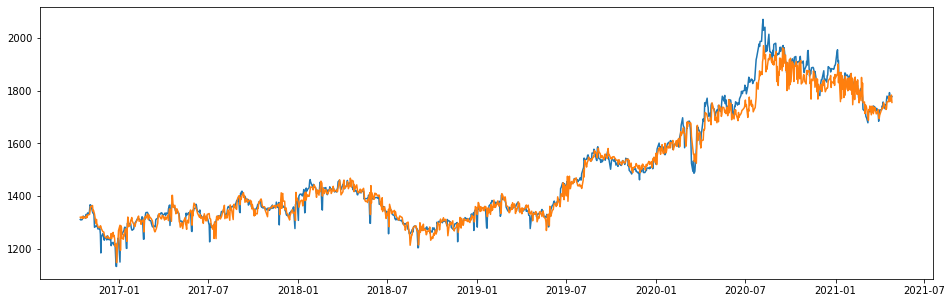

In [10]:
# 1990년 이후 금 시세 + 평균
fig, ax = plt.subplots(figsize=(16,5))
plt.plot(result_df['y'])
plt.plot(result_df['lstm'])
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(result_df['y'], result_df['lstm'])**0.5
print(RMSE)

34.224128176582255


In [11]:
from sklearn.metrics import r2_score
print(r2_score(result_df['y'],result_df['lstm']))

0.9741728394191118
